# Wifi location

###### Oriol Ordi, February 2020

# Table Of Content:

* [1. Summary and Dataset Loading](#Summary)   
* [2. Preprocessing](#Preprocessing)    
* [3. Modelling](#Modelling) 
    * [3.1. Building](#Building)
    * [3.2. Floor](#Floor)
    * [3.1. Latitude](#Latitude)
    * [3.1. Longitude](#Longitude)
* [4. Results](#Results)

## <a class="anchor" id="Summary"> 1. Summary and Dataset Loading </a>

The goal of this project is to investigate the feasibility of using "Wifi fingerprinting" to determine a person's location in indoor spaces, where systems like GPS generally don't work, making the use of a different technology a necessity.  

Wifi fingerprinting uses the signals from multiple wifi hotspots within a space to determine location, analogously to how GPS uses satellite signals.  

Using a large database of Wifi fingerprints on a multi-building industrial campus with a location (building, floor, and location ID) associated with each fingerprint, the project will focus on evaluating multiple machine learning models (together with several pre-processing techniques) to see which produces the best result to be incorporated into a smartphone app for indoor locationing.

### Function to hide cell code (ignore this please)

In [1]:
# ---- FUNCTION TO HIDE CELL CODE ----#

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide upper code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Load the necessary libraries

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from math import sqrt
from math import pi
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

hide_toggle()

### Reminder of how to access rows and columns of a dataframe (ignore this please)

In [3]:
# Reminder of how to access the rows and the columns of a dataframe (as well as their length)

# Access the rows
#####df.index
# Access the columns
#####df.columns
# Access the number of rows
#####len(df.index)
# Access the number of columns
######len(df.columns)

hide_toggle()

### Load the datasets and make a copy of them to work with

In [4]:
# Load the datasets
path_training = 'datasets/trainingData.csv'
path_validation = 'datasets/validationData.csv'
dataset_training = pd.read_csv(path_training)
dataset_validation = pd.read_csv(path_validation)

hide_toggle()

In [5]:
# Make a copy of the training dataset to work with
df = dataset_training.copy()
df_val = dataset_validation.copy()

hide_toggle()

## <a class="anchor" id="Preprocessing"> 2. Preprocessing </a>

### Remove unusable columns

The SPACEID and the RELATIVEPOSITION are missing in the validation set. Thus, both columns are removed from both datasets since they will not be able to be used in the prediction.

In [6]:
# Drop the SPACEID and RELATIVEPOSITION columns
df = df.drop(['SPACEID','RELATIVEPOSITION'], axis=1)
df_val = df_val.drop(['SPACEID','RELATIVEPOSITION'], axis=1)

hide_toggle()

### Check the data types and change the necessary ones

In [7]:
# Check the data types
pd.set_option('display.max_columns', None)
display(pd.DataFrame(df.dtypes).transpose())

# Change the necessary data types to categorical
df.FLOOR = df.FLOOR.astype('category')
df.BUILDINGID = df.BUILDINGID.astype('category')

# Check that the changes have indeed been performed
display(pd.DataFrame(df.dtypes).transpose())

hide_toggle()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,WAP041,WAP042,WAP043,WAP044,WAP045,WAP046,WAP047,WAP048,WAP049,WAP050,WAP051,WAP052,WAP053,WAP054,WAP055,WAP056,WAP057,WAP058,WAP059,WAP060,WAP061,WAP062,WAP063,WAP064,WAP065,WAP066,WAP067,WAP068,WAP069,WAP070,WAP071,WAP072,WAP073,WAP074,WAP075,WAP076,WAP077,WAP078,WAP079,WAP080,WAP081,WAP082,WAP083,WAP084,WAP085,WAP086,WAP087,WAP088,WAP089,WAP090,WAP091,WAP092,WAP093,WAP094,WAP095,WAP096,WAP097,WAP098,WAP099,WAP100,WAP101,WAP102,WAP103,WAP104,WAP105,WAP106,WAP107,WAP108,WAP109,WAP110,WAP111,WAP112,WAP113,WAP114,WAP115,WAP116,WAP117,WAP118,WAP119,WAP120,WAP121,WAP122,WAP123,WAP124,WAP125,WAP126,WAP127,WAP128,WAP129,WAP130,WAP131,WAP132,WAP133,WAP134,WAP135,WAP136,WAP137,WAP138,WAP139,WAP140,WAP141,WAP142,WAP143,WAP144,WAP145,WAP146,WAP147,WAP148,WAP149,WAP150,WAP151,WAP152,WAP153,WAP154,WAP155,WAP156,WAP157,WAP158,WAP159,WAP160,WAP161,WAP162,WAP163,WAP164,WAP165,WAP166,WAP167,WAP168,WAP169,WAP170,WAP171,WAP172,WAP173,WAP174,WAP175,WAP176,WAP177,WAP178,WAP179,WAP180,WAP181,WAP182,WAP183,WAP184,WAP185,WAP186,WAP187,WAP188,WAP189,WAP190,WAP191,WAP192,WAP193,WAP194,WAP195,WAP196,WAP197,WAP198,WAP199,WAP200,WAP201,WAP202,WAP203,WAP204,WAP205,WAP206,WAP207,WAP208,WAP209,WAP210,WAP211,WAP212,WAP213,WAP214,WAP215,WAP216,WAP217,WAP218,WAP219,WAP220,WAP221,WAP222,WAP223,WAP224,WAP225,WAP226,WAP227,WAP228,WAP229,WAP230,WAP231,WAP232,WAP233,WAP234,WAP235,WAP236,WAP237,WAP238,WAP239,WAP240,WAP241,WAP242,WAP243,WAP244,WAP245,WAP246,WAP247,WAP248,WAP249,WAP250,WAP251,WAP252,WAP253,WAP254,WAP255,WAP256,WAP257,WAP258,WAP259,WAP260,WAP261,WAP262,WAP263,WAP264,WAP265,WAP266,WAP267,WAP268,WAP269,WAP270,WAP271,WAP272,WAP273,WAP274,WAP275,WAP276,WAP277,WAP278,WAP279,WAP280,WAP281,WAP282,WAP283,WAP284,WAP285,WAP286,WAP287,WAP288,WAP289,WAP290,WAP291,WAP292,WAP293,WAP294,WAP295,WAP296,WAP297,WAP298,WAP299,WAP300,WAP301,WAP302,WAP303,WAP304,WAP305,WAP306,WAP307,WAP308,WAP309,WAP310,WAP311,WAP312,WAP313,WAP314,WAP315,WAP316,WAP317,WAP318,WAP319,WAP320,WAP321,WAP322,WAP323,WAP324,WAP325,WAP326,WAP327,WAP328,WAP329,WAP330,WAP331,WAP332,WAP333,WAP334,WAP335,WAP336,WAP337,WAP338,WAP339,WAP340,WAP341,WAP342,WAP343,WAP344,WAP345,WAP346,WAP347,WAP348,WAP349,WAP350,WAP351,WAP352,WAP353,WAP354,WAP355,WAP356,WAP357,WAP358,WAP359,WAP360,WAP361,WAP362,WAP363,WAP364,WAP365,WAP366,WAP367,WAP368,WAP369,WAP370,WAP371,WAP372,WAP373,WAP374,WAP375,WAP376,WAP377,WAP378,WAP379,WAP380,WAP381,WAP382,WAP383,WAP384,WAP385,WAP386,WAP387,WAP388,WAP389,WAP390,WAP391,WAP392,WAP393,WAP394,WAP395,WAP396,WAP397,WAP398,WAP399,WAP400,WAP401,WAP402,WAP403,WAP404,WAP405,WAP406,WAP407,WAP408,WAP409,WAP410,WAP411,WAP412,WAP413,WAP414,WAP415,WAP416,WAP417,WAP418,WAP419,WAP420,WAP421,WAP422,WAP423,WAP424,WAP425,WAP426,WAP427,WAP428,WAP429,WAP430,WAP431,WAP432,WAP433,WAP434,WAP435,WAP436,WAP437,WAP438,WAP439,WAP440,WAP441,WAP442,WAP443,WAP444,WAP445,WAP446,WAP447,WAP448,WAP449,WAP450,WAP451,WAP452,WAP453,WAP454,WAP455,WAP456,WAP457,WAP458,WAP459,WAP460,WAP461,WAP462,WAP463,WAP464,WAP465,WAP466,WAP467,WAP468,WAP469,WAP470,WAP471,WAP472,WAP473,WAP474,WAP475,WAP476,WAP477,WAP478,WAP479,WAP480,WAP481,WAP482,WAP483,WAP484,WAP485,WAP486,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,USERID,PHONEID,TIMESTAMP
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,in

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,WAP041,WAP042,WAP043,WAP044,WAP045,WAP046,WAP047,WAP048,WAP049,WAP050,WAP051,WAP052,WAP053,WAP054,WAP055,WAP056,WAP057,WAP058,WAP059,WAP060,WAP061,WAP062,WAP063,WAP064,WAP065,WAP066,WAP067,WAP068,WAP069,WAP070,WAP071,WAP072,WAP073,WAP074,WAP075,WAP076,WAP077,WAP078,WAP079,WAP080,WAP081,WAP082,WAP083,WAP084,WAP085,WAP086,WAP087,WAP088,WAP089,WAP090,WAP091,WAP092,WAP093,WAP094,WAP095,WAP096,WAP097,WAP098,WAP099,WAP100,WAP101,WAP102,WAP103,WAP104,WAP105,WAP106,WAP107,WAP108,WAP109,WAP110,WAP111,WAP112,WAP113,WAP114,WAP115,WAP116,WAP117,WAP118,WAP119,WAP120,WAP121,WAP122,WAP123,WAP124,WAP125,WAP126,WAP127,WAP128,WAP129,WAP130,WAP131,WAP132,WAP133,WAP134,WAP135,WAP136,WAP137,WAP138,WAP139,WAP140,WAP141,WAP142,WAP143,WAP144,WAP145,WAP146,WAP147,WAP148,WAP149,WAP150,WAP151,WAP152,WAP153,WAP154,WAP155,WAP156,WAP157,WAP158,WAP159,WAP160,WAP161,WAP162,WAP163,WAP164,WAP165,WAP166,WAP167,WAP168,WAP169,WAP170,WAP171,WAP172,WAP173,WAP174,WAP175,WAP176,WAP177,WAP178,WAP179,WAP180,WAP181,WAP182,WAP183,WAP184,WAP185,WAP186,WAP187,WAP188,WAP189,WAP190,WAP191,WAP192,WAP193,WAP194,WAP195,WAP196,WAP197,WAP198,WAP199,WAP200,WAP201,WAP202,WAP203,WAP204,WAP205,WAP206,WAP207,WAP208,WAP209,WAP210,WAP211,WAP212,WAP213,WAP214,WAP215,WAP216,WAP217,WAP218,WAP219,WAP220,WAP221,WAP222,WAP223,WAP224,WAP225,WAP226,WAP227,WAP228,WAP229,WAP230,WAP231,WAP232,WAP233,WAP234,WAP235,WAP236,WAP237,WAP238,WAP239,WAP240,WAP241,WAP242,WAP243,WAP244,WAP245,WAP246,WAP247,WAP248,WAP249,WAP250,WAP251,WAP252,WAP253,WAP254,WAP255,WAP256,WAP257,WAP258,WAP259,WAP260,WAP261,WAP262,WAP263,WAP264,WAP265,WAP266,WAP267,WAP268,WAP269,WAP270,WAP271,WAP272,WAP273,WAP274,WAP275,WAP276,WAP277,WAP278,WAP279,WAP280,WAP281,WAP282,WAP283,WAP284,WAP285,WAP286,WAP287,WAP288,WAP289,WAP290,WAP291,WAP292,WAP293,WAP294,WAP295,WAP296,WAP297,WAP298,WAP299,WAP300,WAP301,WAP302,WAP303,WAP304,WAP305,WAP306,WAP307,WAP308,WAP309,WAP310,WAP311,WAP312,WAP313,WAP314,WAP315,WAP316,WAP317,WAP318,WAP319,WAP320,WAP321,WAP322,WAP323,WAP324,WAP325,WAP326,WAP327,WAP328,WAP329,WAP330,WAP331,WAP332,WAP333,WAP334,WAP335,WAP336,WAP337,WAP338,WAP339,WAP340,WAP341,WAP342,WAP343,WAP344,WAP345,WAP346,WAP347,WAP348,WAP349,WAP350,WAP351,WAP352,WAP353,WAP354,WAP355,WAP356,WAP357,WAP358,WAP359,WAP360,WAP361,WAP362,WAP363,WAP364,WAP365,WAP366,WAP367,WAP368,WAP369,WAP370,WAP371,WAP372,WAP373,WAP374,WAP375,WAP376,WAP377,WAP378,WAP379,WAP380,WAP381,WAP382,WAP383,WAP384,WAP385,WAP386,WAP387,WAP388,WAP389,WAP390,WAP391,WAP392,WAP393,WAP394,WAP395,WAP396,WAP397,WAP398,WAP399,WAP400,WAP401,WAP402,WAP403,WAP404,WAP405,WAP406,WAP407,WAP408,WAP409,WAP410,WAP411,WAP412,WAP413,WAP414,WAP415,WAP416,WAP417,WAP418,WAP419,WAP420,WAP421,WAP422,WAP423,WAP424,WAP425,WAP426,WAP427,WAP428,WAP429,WAP430,WAP431,WAP432,WAP433,WAP434,WAP435,WAP436,WAP437,WAP438,WAP439,WAP440,WAP441,WAP442,WAP443,WAP444,WAP445,WAP446,WAP447,WAP448,WAP449,WAP450,WAP451,WAP452,WAP453,WAP454,WAP455,WAP456,WAP457,WAP458,WAP459,WAP460,WAP461,WAP462,WAP463,WAP464,WAP465,WAP466,WAP467,WAP468,WAP469,WAP470,WAP471,WAP472,WAP473,WAP474,WAP475,WAP476,WAP477,WAP478,WAP479,WAP480,WAP481,WAP482,WAP483,WAP484,WAP485,WAP486,WAP487,WAP488,WAP489,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,USERID,PHONEID,TIMESTAMP
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,in

The FLOOR and the BUILDINGID are better characterized by a categorical variables, thus they are changed to categorical variables.

### Check columns and rows that have ALL values of 100 in the WAP and eliminate them

The columns that have ALL values of 100 in the WAPs are basically WAPs that don't register any signal for any of the data points. These columns, thus, convey no information and can be diposed of.  
Similarly, the rows that have ALL values of 100 in the WAPs are observations that were not detected by any of the WAPs and can also be removed.

In [8]:
# Get the WAP columns (aka. columns that start with WAP)
wap_cols_initial = [col for col in df if col.startswith('WAP')]


# Calculate a "fake percentage" of the rows, where if the whole row has 100 in every WAP, the percentage
# will be 100%
row_percentage = df[wap_cols_initial].sum(axis=1) / (len(df[wap_cols_initial].columns))
# Get the indices of the rows that have 100 in every WAP
eliminated_rows_indices = [i for i in range(len(df.index)) if row_percentage[i] == 100]
# Eliminate the rows that have 100 in every WAP
df = df.drop(eliminated_rows_indices, axis = 0)


# Check that all remaining rows have at least 3 WAPS different than 100
df_test = df.replace(100,0)
df_test = pd.DataFrame(df_test.astype(bool).sum(axis=1))
df_test = df_test[df_test >= 3]

stringtest = str(df_test.isna().sum())
print('Number of rows that do not have at least 3 WAPs with signal = ' + str(df_test.isna().sum().values) + '\n')

# Calculate a "fake percentage" of the columns, where if the whole column has a WAP of 100, the percentage
# of that WAP will be 100%
col_percentage = (df[wap_cols_initial].sum(axis=0)) / len(df[wap_cols_initial].index)
# Get the indices of the columns that have 100 in every row
eliminated_cols_indices = [i for i in range(len(df[wap_cols_initial].columns)) if col_percentage[i] == 100]
# Eliminate the WAP columns that have all 100
df = df.drop(df.columns[eliminated_cols_indices], axis = 1)


# Recalculate the the WAP columns (aka. columns that start with WAP) to get the remaining WAP columns for future use
wap_cols = [col for col in df if col.startswith('WAP')]


# See the number of columns and rows that were removed
print("Number of columns removed: %d" % (len(wap_cols_initial) - len(wap_cols)))
print("Number of rows removed : %d" % (len(dataset_training.index) - len(df.index)))

hide_toggle()

Number of rows that do not have at least 3 WAPs with signal = [0]

Number of columns removed: 55
Number of rows removed : 76


### Check for duplicated rows and eliminate them

In [9]:
# Check for rows where the WAP values are duplicated
duplicated_rows_wap = df[wap_cols].duplicated(keep = False)
print('Number of duplicated rows: %d' %sum(duplicated_rows_wap))


# Eliminate the duplicated rows
df = df.drop_duplicates(wap_cols, keep = False)
df = df.reset_index(drop = True)

hide_toggle()

Number of duplicated rows: 822


### Check for class imbalance

Building 0: 5237 rows
Building 1: 4800 rows
Building 2: 9002 rows


Floor 0: 4273 rows
Floor 1: 4714 rows
Floor 2: 4415 rows
Floor 3: 4979 rows
Floor 4: 658 rows


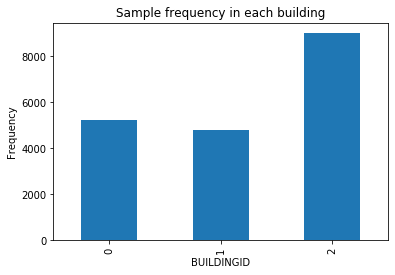

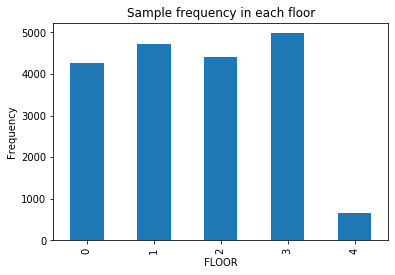

In [10]:
# Check for class imbalance in the floor and building variables
building_id_list = set(df.BUILDINGID)
for i in building_id_list:
    print('Building ' + str(i) + ': ' + str(len(df.loc[:,'BUILDINGID'][df.loc[:,'BUILDINGID'] == i])) + ' rows')

print('\n')

floor_id_list = set(df.FLOOR)
for i in floor_id_list :
    print('Floor ' + str(i) + ': ' + str(len(df.loc[:,'FLOOR'][df.loc[:,'FLOOR'] == i])) + ' rows')


# Histogram of building and floor to show the class imbalance
df.groupby('BUILDINGID').size().plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Sample frequency in each building')
plt.show()

df.groupby('FLOOR').size().plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Sample frequency in each floor')
plt.show()

hide_toggle()

The building 2 and the floor 4 have class imbalance.  
The buidling 2 class imbalance COULD be treated with downsampling.  
The floor 4 class imbalance COULD be treated with upsampling.

### Dealing with the class imbalance

As seen later (in the building and floor prediction), there's no need to deal with the class imbalance, since the confusion matrix shows that the imbalanced classes don't shift significantly the predictions.

### Scatter plot of longitude vs latitude in training and test sets

To have a better idea of how the observations are physically spread, the longitude and latitude are plotted, and the buildings are shown with different colors.

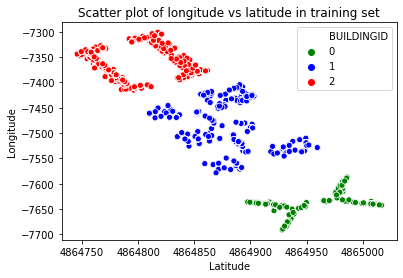

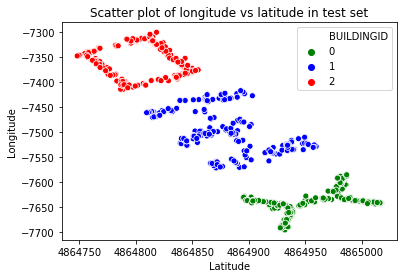

In [11]:
# Scatter plot of longitude vs latitude in training set
sns.scatterplot(data = df, x = "LATITUDE", y = "LONGITUDE", hue = "BUILDINGID",
                    palette = ['green', 'blue', 'red'], legend = 'full')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter plot of longitude vs latitude in training set')
plt.show()


# Scatter plot of longitude vs latitude in testing set
sns.scatterplot(data = df_val, x = "LATITUDE", y = "LONGITUDE", hue = "BUILDINGID",
                    palette = ['green', 'blue', 'red'], legend = 'full')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter plot of longitude vs latitude in test set')
plt.show()

hide_toggle()

### Change the WAP values to make more sense for the modelling

Formula used to make more sense of the modelling. It consist of undoing the transformation that the original data had. Thus, the intensity signal is converted back to intensity from the Loss logarithmic state the dataset was presented in.

In [12]:
# Formula to change from Loss to intensity : d = (landa / 4 * pi) * (10**(WAP_VALUE/20)
# where landa = c / f
# where c = lightspeed (3*(10**8) m/s) and f = radio wave frequency (in this case 2.4 GHz or 2.4*(10**9) Hz)

# Change the WAP values back from Loss to distance in the training set
for col in wap_cols :
    df.loc[:,col] = (10**(df.loc[:,col]/20)) * ((3*(10**8)) / (2.4*(10**9)) / 4 * pi)
df[wap_cols] = df[wap_cols].replace((10**(100/20)* ((3*(10**8)) / (2.4*(10**9)) / 4 * pi)),0)


# Change the WAP values back from Loss to distance in the testing set
for col in wap_cols :
    df_val.loc[:,col] = (10**(df_val.loc[:,col]/20)) * ((3*(10**8)) / (2.4*(10**9)) / 4 * pi)
df_val[wap_cols] = df_val[wap_cols].replace((10**(100/20)* ((3*(10**8)) / (2.4*(10**9)) / 4 * pi)),0)

hide_toggle()

### Cells priorly used for error analysis and for triangulation purposes (please ignore them)

In [13]:
#df = df[(df['USERID'] != 6) & (df['PHONEID'] != 19)]
#df = df[(df['USERID'] != 11) & (df['PHONEID'] != 13)]
#df = df.reset_index(drop = True)



#df = df.drop(set(list(wap_latitude) + list(wap_longitude)),axis=1)
#wap_cols = [col for col in df if col.startswith('WAP')]

hide_toggle()

In [14]:
#top_n = 3

#df[wap_cols] = pd.DataFrame(np.where(df[wap_cols].rank(axis=1,method='min',ascending=False) > top_n, 0, df[wap_cols]),
#                  columns=df[wap_cols].columns)

hide_toggle()

### Normalize the WAP values in each row

To make sure that that the stength of the signal is the same for every phone and user ID, the ROWS of the dataset are normalized.

In [15]:
# Normalize the WAP values in each row for the training set
std_scale = MinMaxScaler().fit(df[wap_cols].transpose())
df_std = std_scale.transform(df[wap_cols].transpose())
df[wap_cols] = pd.DataFrame(np.transpose(df_std))


# Normalize the WAP values in each row for the testing set
std_scale = MinMaxScaler().fit(df_val[wap_cols].transpose())
df_std = std_scale.transform(df_val[wap_cols].transpose())
df_val[wap_cols] = pd.DataFrame(np.transpose(df_std))

hide_toggle()

### PCA Analysis

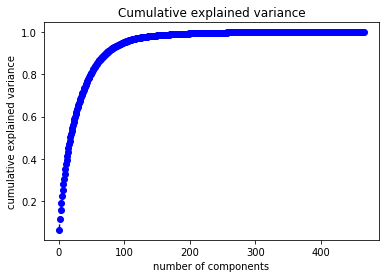

In [16]:
# Fit the PCA data
pca = PCA(n_components=None)
pca.fit(df[wap_cols])


# Scree plot of the PCA
plt.plot(np.arange(1,(len(wap_cols)+1)), np.cumsum(pca.explained_variance_ratio_),
         linestyle='--', marker='o', color='b')

plt.title("Cumulative explained variance")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

hide_toggle()

From the scree plot, a number of 100 components can be chosen. Those will explain most of the variance of the features and save computational time.

In [17]:
# Select the number of components from the PCA
number_of_components = 100


# Fit and transform the WAPs with 100 components
pca = PCA(n_components = number_of_components)  #Number of components to keep. Default -> all components kept
pca.fit(df[wap_cols])

pc_data = pca.transform(df[wap_cols])
pc_data_val = pca.transform(df_val[wap_cols])


# Eliminate the WAP columns and substitute them by the 100 components of the PCA
df = df.drop(wap_cols, axis = 1)
df_val = df_val.drop(wap_cols, axis = 1)

wap_cols = list(range(0,number_of_components)) ###

df[wap_cols] = pd.DataFrame(pc_data)
df_val[wap_cols] = pd.DataFrame(pc_data_val)

## <a class="anchor" id="Modelling"> 3. Modelling </a>

### <a class="anchor" id="Building"> 3.1. Building </a>

### Separate predictors and target and train set and test set

In [18]:
# Separate predictors and target
X = df[wap_cols]
y = df['BUILDINGID']
X_val = df_val[wap_cols]
Y_val = df_val['BUILDINGID']


# Separate train set and test set
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
                                                                test_size=0.20,
                                                                random_state=1,
                                                                shuffle=True)

hide_toggle()

### Train various models and compare accuracy results

LR: CV accuracy: 0.999147 std: (0.000513)
Test accuracy: 0.999475
Test Kappa: 0.999180
Confusion matrix
[[1040    0    0]
 [   0  997    0]
 [   0    2 1769]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1040
           1       1.00      1.00      1.00       997
           2       1.00      1.00      1.00      1771

    accuracy                           1.00      3808
   macro avg       1.00      1.00      1.00      3808
weighted avg       1.00      1.00      1.00      3808

LDA: CV accuracy: 0.993171 std: (0.002039)
Test accuracy: 0.995273
Test Kappa: 0.992611
Confusion matrix
[[1034    1    5]
 [   0  985   12]
 [   0    0 1771]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1040
           1       1.00      0.99      0.99       997
           2       0.99      1.00      1.00      1771

    accuracy                          

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

RF: CV accuracy: 0.999803 std: (0.000420)
Test accuracy: 0.999737
Test Kappa: 0.999590
Confusion matrix
[[1040    0    0]
 [   0  997    0]
 [   0    1 1770]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1040
           1       1.00      1.00      1.00       997
           2       1.00      1.00      1.00      1771

    accuracy                           1.00      3808
   macro avg       1.00      1.00      1.00      3808
weighted avg       1.00      1.00      1.00      3808



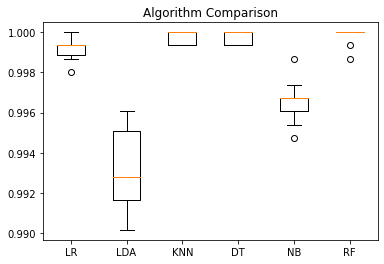

In [19]:
# Define the models to be used
models = []
models.append(('LR', LogisticRegression(solver='liblinear',
                                        multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('XGB', GradientBoostingClassifier()))


# Evaluate each model in turn
results = []
names = []
for name, model in models :
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print('%s: CV accuracy: %f std: (%f)' % (name,
                                             cv_results.mean(),
                                             cv_results.std()))
    print('Test accuracy: %f' % (metrics.accuracy_score(Y_validation, predictions)))
    print('Test Kappa: %f' % (metrics.cohen_kappa_score(Y_validation, predictions)))
    print('Confusion matrix')
    print(metrics.confusion_matrix(Y_validation, predictions))
    print('Classification Report')
    print(metrics.classification_report(Y_validation, predictions))


# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

hide_toggle()

### Select the best model and tune it

There are 2 candidates for the best model for BUILDING identification, which are KNN and RandomForest.  
Both of the models will be tuned and then the best one will be chosen based on the best accuracy on the validation set.

##### Tune the KNN model:

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score : 0.999934
Best parameters:
{'n_neighbors': 1}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   25.1s finished


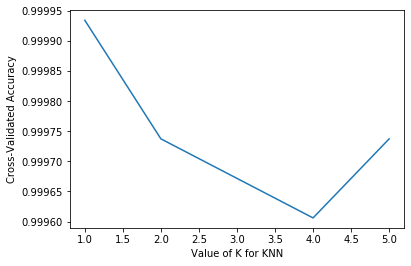

In [20]:
# KNN hyperparameter tunning
k_range = [1,2,3,4,5]
grid_params = {'n_neighbors' : k_range}

gs = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 10)
                 
gs_results = gs.fit(X_train, Y_train)

print('Best score : %f' % gs_results.best_score_)
print('Best parameters:')
print(gs_results.best_params_)

# Plot the accuracy of the different K values
plt.plot(k_range, gs_results.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

hide_toggle()

##### Define the report function, which summarises the best result of the RandomForest RandomizedSearchCV

In [21]:
# Definition of the report function
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

hide_toggle()

##### Tune the RandomForest model:

In [22]:
# Number of trees in random forest
n_estimators = [10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Set the number of iterations for the randomized search cv
n_iter = 30


# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_distributions, n_iter = n_iter)
random_search.fit(X_train, Y_train)


# Report the results of the rank 1 model (the best one) from the RandomizedSearchCV
report(random_search.cv_results_)

hide_toggle()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100

### Test the tuned best model on the validation set (KNN)

In [23]:
# Predict using the KNN model
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X, y)
prediction_building = model.predict(X_val)


# Evaluate the predictions
print('KNN evaluation')
print('Accuracy %f Kappa %f' % (metrics.accuracy_score(Y_val, prediction_building),
                                metrics.cohen_kappa_score(Y_val,prediction_building)))
print('Confusion matrix')
print(metrics.confusion_matrix(Y_val, prediction_building))
print('Classification report')
print(metrics.classification_report(Y_val, prediction_building))

hide_toggle()

KNN evaluation
Accuracy 0.999100 Kappa 0.998577
Confusion matrix
[[536   0   0]
 [  0 306   1]
 [  0   0 268]]
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



### Test the tuned best model on the validation set (RandomForest)

In [24]:
# Predict using the RandomForest model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = None, bootstrap = False)
model.fit(X, y)
prediction_building = model.predict(X_val)


# Evaluate the predictions
print('Random Forest evaluation')
print('Accuracy %f Kappa %f' % (metrics.accuracy_score(Y_val, prediction_building),
                                metrics.cohen_kappa_score(Y_val,prediction_building)))
print('Confusion matrix')
print(metrics.confusion_matrix(Y_val, prediction_building))
print('Classification report')
print(metrics.classification_report(Y_val, prediction_building))


# Save the accuracy of the building
accuracy_building = metrics.accuracy_score(Y_val, prediction_building)

Random Forest evaluation
Accuracy 1.000000 Kappa 1.000000
Confusion matrix
[[536   0   0]
 [  0 307   0]
 [  0   0 268]]
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



The Random forest model gives a better result on the validation test, thus it is the one that will be used.

### <a class="anchor" id="Floor"> 3.2. Floor </a>

### Separate predictors and target and train set and test set

In [25]:
# Separate predictors and target
X = df[wap_cols]
y = df['FLOOR']
X_val = df_val[wap_cols]
Y_val = df_val['FLOOR']


# Separate train set and test set
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
                                                                test_size=0.20,
                                                                random_state=1,
                                                                shuffle=True)

hide_toggle()

### Train various models and compare accuracy results

LR: CV accuracy: 0.969075 std: (0.004157)
Test accuracy: 0.971901
Test Kappa: 0.963154
Confusion matrix
[[865  11   7   0   0]
 [  5 901  13   1   0]
 [  0  10 868   8   1]
 [  0   6  20 972  11]
 [  1   1   2  10  95]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       883
           1       0.97      0.98      0.97       920
           2       0.95      0.98      0.97       887
           3       0.98      0.96      0.97      1009
           4       0.89      0.87      0.88       109

    accuracy                           0.97      3808
   macro avg       0.96      0.95      0.96      3808
weighted avg       0.97      0.97      0.97      3808

LDA: CV accuracy: 0.954434 std: (0.004556)
Test accuracy: 0.957721
Test Kappa: 0.944562
Confusion matrix
[[858  18   7   0   0]
 [ 16 886  17   1   0]
 [  0  13 869   4   1]
 [  0   8  45 944  12]
 [  1   1   5  12  90]]
Classification Report
              precision   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

RF: CV accuracy: 0.987655 std: (0.003634)
Test accuracy: 0.988183
Test Kappa: 0.984500
Confusion matrix
[[881   2   0   0   0]
 [  1 915   4   0   0]
 [  0   6 875   6   0]
 [  1   1   8 993   6]
 [  1   0   2   7  99]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       883
           1       0.99      0.99      0.99       920
           2       0.98      0.99      0.99       887
           3       0.99      0.98      0.99      1009
           4       0.94      0.91      0.93       109

    accuracy                           0.99      3808
   macro avg       0.98      0.97      0.98      3808
weighted avg       0.99      0.99      0.99      3808



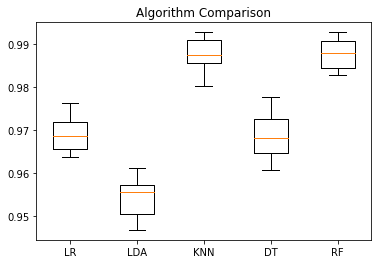

In [26]:
# Define the models to be used
models = []
models.append(('LR', LogisticRegression(solver='liblinear',
                                        multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('XGB', GradientBoostingClassifier()))


# Evaluate each model in turn
results = []
names = []
for name, model in models :
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print('%s: CV accuracy: %f std: (%f)' % (name,
                                             cv_results.mean(),
                                             cv_results.std()))
    print('Test accuracy: %f' % (metrics.accuracy_score(Y_validation, predictions)))
    print('Test Kappa: %f' % (metrics.cohen_kappa_score(Y_validation, predictions)))
    print('Confusion matrix')
    print(metrics.confusion_matrix(Y_validation, predictions))
    print('Classification Report')
    print(metrics.classification_report(Y_validation, predictions))


# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

hide_toggle()

### Select the best model and tune it

There are 2 candidates for the best model for FLOOR identification, which are KNN and RandomForest.  
Both of the models will be tuned and then the best one will be chosen based on the best accuracy on the validation set.

##### Tune the KNN model:

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score : 0.991399
Best parameters:
{'n_neighbors': 1}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.9s finished


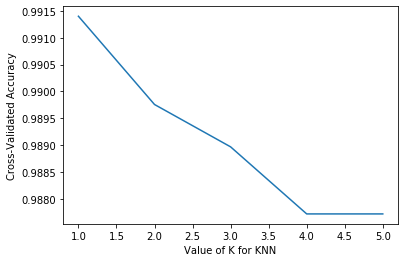

In [27]:
# KNN hyperparameter tunning
k_range = [1,2,3,4,5]
grid_params = {'n_neighbors' : k_range}

gs = GridSearchCV(KNeighborsClassifier(),
                 grid_params,
                 verbose = 1,
                 cv = 10)
                 
gs_results = gs.fit(X_train, Y_train)

print('Best score : %f' % gs_results.best_score_)
print('Best parameters:')
print(gs_results.best_params_)

# Plot the accuracy of the different K values
plt.plot(k_range, gs_results.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

hide_toggle()

##### Tune the RandomForest model:

In [28]:
# Number of trees in random forest
n_estimators = [10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Set the number of iterations for the randomized search cv
n_iter = 30


# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_distributions, n_iter = n_iter)
random_search.fit(X_train, Y_train)


# Report the results of the rank 1 model (the best one) from the RandomizedSearchCV
report(random_search.cv_results_)

hide_toggle()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.991 (std: 0.001)
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}



### Test the tuned best model on the validation set (KNN)

In [29]:
# Predict using the KNN model
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X, y)
prediction_floor = model.predict(X_val)


# Evaluate the predictions
print('KNN evaluation')
print('Accuracy %f Kappa %f' % (metrics.accuracy_score(Y_val, prediction_floor),
                                metrics.cohen_kappa_score(Y_val,prediction_floor)))
print('Confusion matrix')
print(metrics.confusion_matrix(Y_val, prediction_floor))
print('Classification report')
print(metrics.classification_report(Y_val, prediction_floor))

hide_toggle()

KNN evaluation
Accuracy 0.949595 Kappa 0.929398
Confusion matrix
[[124   6   2   0   0]
 [ 16 438   7   1   0]
 [  1  12 288   5   0]
 [  0   0   2 170   0]
 [  0   0   0   4  35]]
Classification report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       132
           1       0.96      0.95      0.95       462
           2       0.96      0.94      0.95       306
           3       0.94      0.99      0.97       172
           4       1.00      0.90      0.95        39

    accuracy                           0.95      1111
   macro avg       0.95      0.94      0.95      1111
weighted avg       0.95      0.95      0.95      1111



### Test the tuned best model on the validation set (RandomForest)

In [30]:
# Predict using the RandomForest model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100, bootstrap = False)
model.fit(X, y)
prediction_floor = model.predict(X_val)


# Evaluate the predictions
print('RandomForest evaluation')
print('Accuracy %f Kappa %f' % (metrics.accuracy_score(Y_val, prediction_floor),
                                metrics.cohen_kappa_score(Y_val,prediction_floor)))
print('Confusion matrix')
print(metrics.confusion_matrix(Y_val, prediction_floor))
print('Classification report')
print(metrics.classification_report(Y_val, prediction_floor))


# Save the accuracy of the floor
accuracy_floor = metrics.accuracy_score(Y_val, prediction_floor)

hide_toggle()

RandomForest evaluation
Accuracy 0.951395 Kappa 0.931686
Confusion matrix
[[119  11   2   0   0]
 [ 10 441   9   2   0]
 [  1  11 292   2   0]
 [  0   0   2 169   1]
 [  0   0   0   3  36]]
Classification report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       132
           1       0.95      0.95      0.95       462
           2       0.96      0.95      0.96       306
           3       0.96      0.98      0.97       172
           4       0.97      0.92      0.95        39

    accuracy                           0.95      1111
   macro avg       0.95      0.94      0.95      1111
weighted avg       0.95      0.95      0.95      1111



The Random forest model gives a better result on the validation test, thus it is the one that will be used.

### <a class="anchor" id="Latitude"> 3.3. Latitude </a>

### Separate predictors and target and train set and test set

In [31]:
# Separate predictors and target
X = df[wap_cols]
y = df['LATITUDE']
X_val = df_val[wap_cols]
Y_val = df_val['LATITUDE']


# Separate train set and test set
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
                                                                test_size=0.20,
                                                                random_state=1,
                                                                shuffle=True)

hide_toggle()

### Train various models and compare accuracy results

KNN: RMSE = 5.924969
DT: RMSE = 8.099688


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

RF: RMSE = 5.518563


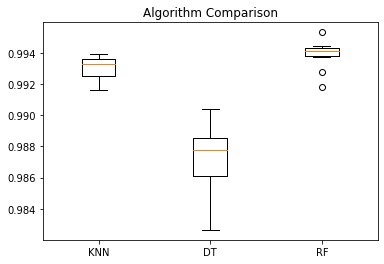

In [32]:
# Define the models to be used
from sklearn.svm import SVR
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
#models.append(('XGB', GradientBoostingRegressor()))


# Evaluate each model in turn
results = []
names = []
for name, model in models :
    kfold = KFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print('%s: RMSE = %f' % (name, sqrt(metrics.mean_squared_error(Y_validation, predictions))))


# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

hide_toggle()

### Select the best model and tune it

There are 2 candidates for the best model for LATITUDE identification, which are KNN and RandomForest.  
Both of the models will be tuned and then the best one will be chosen based on the best RMSE on the validation set.

##### Tune the KNN model:

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.5s finished


Best score : 0.994048
Best parameters:
{'n_neighbors': 2}


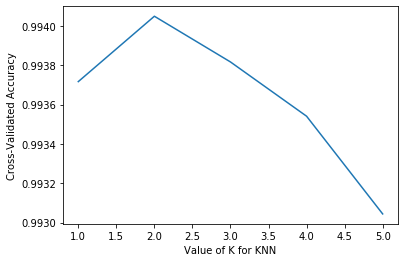

In [33]:
# KNN hyperparameter tunning
k_range = [1,2,3,4,5]
grid_params = {'n_neighbors' : k_range}

gs = GridSearchCV(KNeighborsRegressor(),
                 grid_params,
                 verbose = 1,
                 cv = 10)
                 
gs_results = gs.fit(X_train, Y_train)

print('Best score : %f' % gs_results.best_score_)
print('Best parameters:')
print(gs_results.best_params_)

# Plot the accuracy of the different K values
plt.plot(k_range, gs_results.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

hide_toggle()

##### Tune the Random forest model.

In [34]:
# Number of trees in random forest
n_estimators = [10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Set the number of iterations for the randomized search cv
n_iter = 30


# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_distributions, n_iter = n_iter)
random_search.fit(X_train, Y_train)


# Report the results of the rank 1 model (the best one) from the RandomizedSearchCV
report(random_search.cv_results_)

hide_toggle()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.994 (std: 0.000)
Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}



### Test the tuned model on the validation set (KNN)

In [35]:
# Predict using the KNN model
model = KNeighborsRegressor(n_neighbors = 2)
model.fit(X, y)
prediction_latitude = model.predict(X_val)


# Evaluate the predictions
print('KNN RMSE = %f' % (sqrt(metrics.mean_squared_error(Y_val, prediction_latitude))))

hide_toggle()

KNN RMSE = 8.554582


### Test the tuned model on the validation set (RandomForest)

In [36]:
# Predict using the RandomForest model
model = RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = None, bootstrap = False)
model.fit(X, y)
prediction_latitude = model.predict(X_val)


# Evaluate the predictions
print('Random Forest RMSE = %f' % (sqrt(metrics.mean_squared_error(Y_val, prediction_latitude))))


# Save the RSME of the latitude
RMSE_latitude = sqrt(metrics.mean_squared_error(Y_val, prediction_latitude))

hide_toggle()

Random Forest RMSE = 7.207501


The Random forest model gives a better result on the validation test, thus it is the one that will be used.

### <a class="anchor" id="Longitude"> 3.4. Longitude </a>

### Separate predictors and target and train set and test set

In [37]:
# Separate predictors and target
X = df[wap_cols]
y = df['LONGITUDE']
X_val = df_val[wap_cols]
Y_val = df_val['LONGITUDE']


# Separate train set and test set
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
                                                                test_size=0.20,
                                                                random_state=1,
                                                                shuffle=True)

hide_toggle()

### Train various models and compare accuracy results

KNN: RMSE = 5.830894
DT: RMSE = 8.498173


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

RF: RMSE = 6.284755


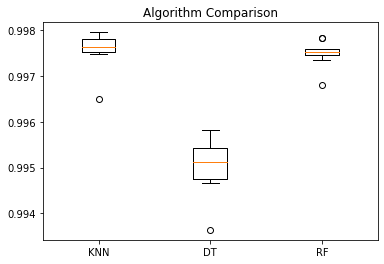

In [38]:
# Define the models to be used
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
#models.append(('XGB', GradientBoostingRegressor()))


# Evaluate each model in turn
results = []
names = []
for name, model in models :
    kfold = KFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print('%s: RMSE = %f' % (name, sqrt(metrics.mean_squared_error(Y_validation, predictions))))


# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

hide_toggle()

### Select the best model and tune it

There are 2 candidates for the best model for LONGITUDE identification, which are KNN and RandomForest.  
Both of the models will be tuned and then the best one will be chosen based on the best RMSE on the validation set.

##### Tune the KNN model.

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.8s finished


Best score : 0.997994
Best parameters:
{'n_neighbors': 2}


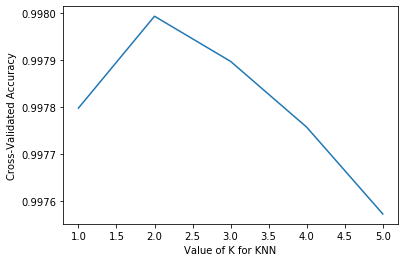

In [39]:
# KNN hyperparameter tunning
k_range = [1,2,3,4,5]
grid_params = {'n_neighbors' : k_range}

gs = GridSearchCV(KNeighborsRegressor(),
                 grid_params,
                 verbose = 1,
                 cv = 10)
                 
gs_results = gs.fit(X_train, Y_train)

print('Best score : %f' % gs_results.best_score_)
print('Best parameters:')
print(gs_results.best_params_)

# Plot the accuracy of the different K values
plt.plot(k_range, gs_results.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

hide_toggle()

##### Tune the Random forest model.

In [40]:
# Number of trees in random forest
n_estimators = [10, 50, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_distributions = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Set the number of iterations for the randomized search cv
n_iter = 30


# Perform the RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_distributions, n_iter = n_iter)
random_search.fit(X_train, Y_train)


# Report the results of the rank 1 model (the best one) from the RandomizedSearchCV
report(random_search.cv_results_)

hide_toggle()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.998 (std: 0.000)
Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}



### Test the tuned model on the validation set (KNN)

In [41]:
# Predict using the KNN model
model = KNeighborsRegressor(n_neighbors = 2)
model.fit(X, y)
prediction_longitude = model.predict(X_val)


# Evaluate the predictions
print('KNN RMSE = %f' % (sqrt(metrics.mean_squared_error(Y_val, prediction_longitude))))


# Save the RSME of the latitude
RMSE_longitude = sqrt(metrics.mean_squared_error(Y_val, prediction_longitude))

hide_toggle()

KNN RMSE = 8.290133


### Test the tuned model on the validation set (RandomForest)

In [42]:
# Predict using the RandomForest model
model = RandomForestRegressor(n_estimators = 50, min_samples_split = 10, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 100, bootstrap = False)
model.fit(X, y)
prediction_longitude = model.predict(X_val)


# Evaluate the predictions
print('Random Forest RMSE = %f' % (sqrt(metrics.mean_squared_error(Y_val, prediction_longitude))))


# Save the RSME of the latitude
RMSE_longitude = sqrt(metrics.mean_squared_error(Y_val, prediction_longitude))

hide_toggle()

Random Forest RMSE = 7.936162


The Random forest model gives a better result on the validation test, thus it is the one that will be used.

## <a class="anchor" id="Results"> 4. Results </a>

### Building accuracy

In [43]:
print('The accuracy of the building prediction is: %.2f' % (accuracy_building*100) + '%')

hide_toggle()

The accuracy of the building prediction is: 100.00%


### Floor accuracy

In [44]:
print('The accuracy of the floor prediction is: %.2f' % (accuracy_floor*100) + '%')

hide_toggle()

The accuracy of the floor prediction is: 95.14%


### Latitude RMSE

In [45]:
print('The RMSE of the latitude prediction is: %.2f' % (RMSE_latitude))

hide_toggle()

The RMSE of the latitud prediction is: 7.21


### Longitude RMSE

In [46]:
print('The RMSE of the longitude prediction is: %.2f' % (RMSE_longitude))

hide_toggle()

The RMSE of the longitude prediction is: 7.94


## Final error formula

The metric used for the final error formula is the third quartile (75th percentile) of the error in all test samples.

In [49]:
# Calculate the Euclidian distance between prediction and actual value (assuming flat earth)
distance_squared = (df_val['LATITUDE'] - prediction_latitude)**2 + (df_val['LONGITUDE'] - prediction_longitude)**2
distance_root = distance_squared.apply(lambda x: sqrt(x))
# Calculate penalyty for misclassifying floor
floor = np.abs(df_val['FLOOR'] - prediction_floor) * 4
# Calculate penalyty for misclassifying building
building = (df_val['BUILDINGID'] != prediction_building) * 50


# Calculate final score using distance, floor, and building
distance_75 = np.percentile(distance_root + floor + building, 75)
print('Final error: %f' % distance_75)

hide_toggle()

Final error: 10.385804
